In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import BaggingRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('./nfl_data/weekly/cbs_weekly/passing_through_week-23.csv')
df.head()

,Player,Game,FPTS Fantasy Points,CMP Pass Completions,ATT Pass Attempts,YDS Passing Yards,TD Touchdown Passes,INT Interceptions Thrown,ATT Rushing Attempts,YDS Rushing Yards,TD Rushing Touchdowns,Week,Pos
0,Josh Allen,BUF 47 - NE 17,48,21,25,308,5,0,6,66,0,19,QB
1,Patrick Mahomes,KC 42 - PIT 21,46,30,39,404,5,1,3,29,0,19,QB
2,Matthew Stafford,LAR 34 - ARI 11,28,13,17,202,2,0,6,22,1,19,QB
3,Dak Prescott,SF 23 - DAL 17,22,23,43,254,1,1,4,27,1,19,QB
4,Tom Brady,TB 31 - PHI 15,22,29,37,271,2,0,0,0,0,19,QB


In [3]:
df.columns

Index(['Player', 'Game', 'FPTS  Fantasy Points', 'CMP  Pass Completions',
       'ATT  Pass Attempts', 'YDS  Passing Yards', 'TD  Touchdown Passes',
       'INT  Interceptions Thrown', 'ATT  Rushing Attempts',
       'YDS  Rushing Yards', 'TD  Rushing Touchdowns', 'Week', 'Pos'],
      dtype='object')

In [4]:
df.drop(columns = 'Pos', inplace = True)

## Level 1 Model

In [5]:
# Create X and y
X = df.drop(columns = ['Player', 'Game', 'FPTS  Fantasy Points'])
y = df['FPTS  Fantasy Points']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
model1 = Pipeline([
    ('ss', StandardScaler()),
    ('lasso', LassoCV())
])
model2 = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsRegressor())
])
model3 = BaggingRegressor()

from: https://git.generalassemb.ly/DSIR-0124/lesson-stacking/blob/master/starter-code.ipynb
Before we fit these models, we need to get predictions to be used as features for our Level 2 model. It's important that the predictions be out of sample to avoid the negative effects of overfitting. Thankfully, scikit-learn has a function that does that for us: cross_val_predict. It's very similar to cross_val_score, except now we're getting predictions from our test folds instead of R2 scores.

In the cell below, use cross_val_predict to create a DataFrame of predictions (X_pred_train) for our level 2 model.

In [8]:
lr = LinearRegression()
cross_val_score(lr, X_train, y_train)
# foo.score(X_train, y_train)

array([0.79476147, 0.95891734, 0.96563184, 0.99299506, 0.98751532])

In [9]:
X_pred_train = pd.DataFrame(index=X_train.index)
X_pred_train['model1'] = cross_val_predict(model1, X_train, y_train)
X_pred_train['model2'] = cross_val_predict(model2, X_train, y_train)
X_pred_train['model3'] = cross_val_predict(model3, X_train, y_train)
X_pred_train.head()

,model1,model2,model3
1,45.639699,21.4,26.5
23,19.023037,14.0,16.9
5,20.938888,14.6,19.2
2,27.511748,20.0,16.9
12,3.269404,12.6,4.2


In [10]:
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

BaggingRegressor()

## Level 2 Model

In [13]:
lr = LinearRegression()
cross_val_score(lr, X_pred_train, y_train).mean()

0.9683751983403296

In [14]:
lr.fit(X_pred_train, y_train)
lr.coef_

array([ 1.00333004, -0.17707541,  0.1225466 ])

In [15]:
# Train score
lr.score(X_pred_train, y_train)

0.9884812210668275

In order to get a test score, we'll need to create a DataFrame of predictions using our Level 1 models

In [17]:
X_pred_test = pd.DataFrame()
X_pred_test['model1'] = model1.predict(X_test)
X_pred_test['model2'] = model2.predict(X_test)
X_pred_test['model3'] = model3.predict(X_test)

In [18]:
# Test Score
lr.score(X_pred_test, y_test)

0.9920471277136842

In [19]:
residuals = y_test - lr.predict(X_pred_test)

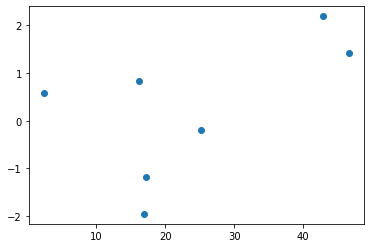

In [22]:
plt.scatter(lr.predict(X_pred_test), residuals);

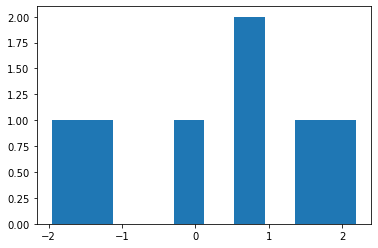

In [23]:
plt.hist(residuals);

##  Stacking Regressor

In [25]:
params = {'knn_pipe__knn__n_neighbors': [5, 6]}
knn_pipe = Pipeline([
        ('ss', StandardScaler()),
        ('knn', KNeighborsRegressor())
    ])
gs = GridSearchCV(knn_pipe, param_grid=params)

In [26]:
# Create the model
level1_models = [
    ('bag', BaggingRegressor()),
    ('knn_pipe', Pipeline([
        ('ss', StandardScaler()),
        ('knn', KNeighborsRegressor())
    ])),
    ('lasso_pipe', Pipeline([
        ('ss', StandardScaler()),
        ('lasso', LassoCV())
    ]))
]

stack = StackingRegressor(estimators=level1_models, final_estimator=LinearRegression())

In [29]:
# Cross-val score
cross_val_score(stack, X_train, y_train).mean()

0.9530948844259921

In [31]:
# Fit
stack.fit(X_train, y_train);

In [32]:
# Train score
stack.score(X_train, y_train)

0.9974846024396149

In [33]:
# Test score
stack.score(X_test, y_test)

0.9966445915768032